In [19]:
!git clone -b batch_size https://github.com/sushmanthreddy/segment-anything.git

fatal: destination path 'segment-anything' already exists and is not an empty directory.


In [20]:
%cd segment-anything/

/kaggle/working/segment-anything


In [21]:
ls -a

./       .gitignore          README.md   notebooks/                  setup.cfg
../      CODE_OF_CONDUCT.md  assets/     scripts/                    setup.py
.flake8  CONTRIBUTING.md     demo/       segment_anything/
.git/    LICENSE             linter.sh*  segment_anything.egg-info/


In [22]:
!pip install -e .

Obtaining file:///kaggle/working/segment-anything
  Preparing metadata (setup.py) ... done
  Attempting uninstall: segment-anything
    Found existing installation: segment-anything 1.0
    Uninstalling segment-anything-1.0:
      Successfully uninstalled segment-anything-1.0
  Running setup.py develop for segment-anything


In [23]:

import numpy as np
import matplotlib.pyplot as plt
import os

join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F
import argparse

In [24]:
%cd ..

/kaggle/working


In [25]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2)
    )

In [50]:
def cellsam_infernce(cellsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :]

    sparse_embeddings, dense_embeddings = cellsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    
    low_res_logits, _ = cellsam_model.mask_decoder(
        image_embeddings=img_embed,  # (B, 256, 64, 64)
        image_pe=cellsam_model.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
        multimask_output=False,
    )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().detach().cpu().numpy()  # (256, 256)
    cellsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return cellsam_seg

In [32]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2023-10-06 21:48:26--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.224.2.6, 13.224.2.21, 13.224.2.42, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.224.2.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   225MB/s    in 1.6s    

2023-10-06 21:48:28 (225 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [ ]:
!pip install gdown

In [ ]:
!gdown --id 1uBcGjlFQBLGCSzg5PZQLLKcUnTfaUlL

In [37]:
# -*- coding: utf-8 -*-
import torch

# %% convert medsam model checkpoint to sam checkpoint format for convenient inference
sam_ckpt_path = "/kaggle/working/sam_vit_b_01ec64.pth"
cellsam_ckpt_path = "/kaggle/working/cellsam_model_best.pth"
save_path = "/kaggle/working/cellsam_conv_ckpt.pth"
multi_gpu_ckpt = False  # set as True if the model is trained with multi-gpu

sam_ckpt = torch.load(sam_ckpt_path)
medsam_ckpt = torch.load(cellsam_ckpt_path)
sam_keys = sam_ckpt.keys()
for key in sam_keys:
    if not multi_gpu_ckpt:
        sam_ckpt[key] = medsam_ckpt["model"][key]
    else:
        sam_ckpt[key] = medsam_ckpt["model"]["module." + key]

torch.save(sam_ckpt, save_path)

In [29]:
if torch.cuda.is_available():
    # CUDA is available, and you can perform GPU operations
    print("CUDA is available!")
    device = torch.device("cuda:0")  # This assumes you want the first GPU device
    print(f"Device name: {torch.cuda.get_device_name(device)}")
else:
    # CUDA is not available
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")




CUDA is available!
Device name: Tesla P100-PCIE-16GB


In [55]:
data_path = "/kaggle/input/nucleus-data/nucleus_data/features/F0_16.png"
seg_path = "/kaggle/working/"
box = [95, 240, 190, 350]
checkpoint = "/kaggle/working/cellsam_conv_ckpt.pth"

In [39]:
cellsam_model = sam_model_registry["vit_b"](checkpoint = checkpoint)
cellsam_model = cellsam_model.to(device)
cellsam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [43]:
img_np = io.imread(data_path)
if len(img_np.shape) == 2:
    img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
else:
    img_3c = img_np
H, W, _ = img_3c.shape

In [57]:
img_1024 = transform.resize(
    img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(
    img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
)  # normalize to [0, 1], (H, W, 3)
# convert the shape to (3, H, W)
img_1024_tensor = (
    torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
)

box_np = np.array([box])
# transfer box_np t0 1024x1024 scale
box_1024 = box_np / np.array([W, H, W, H]) * 1024
with torch.no_grad():
    image_embedding = cellsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)

cellsam_seg = cellsam_infernce(cellsam_model, image_embedding, box_1024, H, W)
io.imsave(
    join(seg_path, "seg_" + os.path.basename(data_path)),
    cellsam_seg,
    check_contrast=False,
)

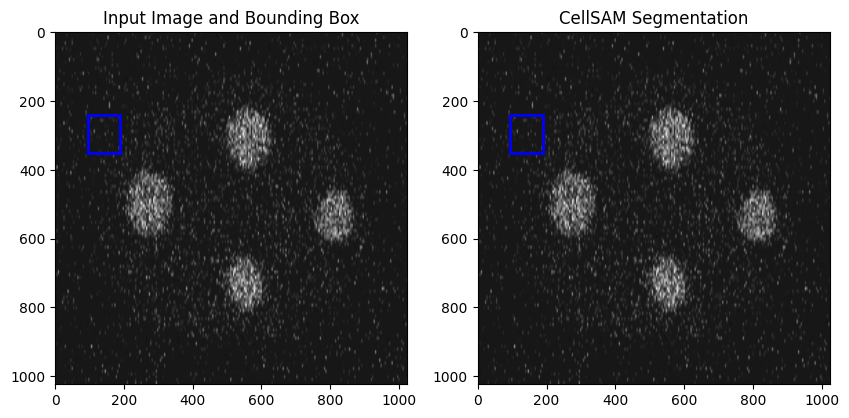

In [58]:
# %% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_3c)
show_box(box_np[0], ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(img_3c)
show_mask(cellsam_seg, ax[1])
show_box(box_np[0], ax[1])
ax[1].set_title("CellSAM Segmentation")
plt.show()
